# Car segmantation for Comma_Kitty images

the car segmentation model is obtained based on the default train pipline from https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

In [ ]:
!pip install segmentation-models-pytorch
!pip install albumentations==0.4.5

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !nvidia-smi

In [ ]:
class Parameters():
  def __init__(self):
    self.data_dir = 'drive/My Drive/Drive/speedchallenge/' #'KITTI/'
    self.image_dir = self.data_dir + 'data/KITTI_COMMA_resized_10fps/'
    self.mask_dir = self.data_dir + 'data/KITTI_COMMA_resized_masks_10fps/'
    
    # Kitti folders
    self.kitti_folder_list = [str(item) for item in list(range(1000,1164))]
    self.kitti_folder_list.pop(142)
    # Comma folders
    self.comma_folder_list = [str(item) for item in list(range(100,185))]
    # My data set folders
    self.my_folders = [str(item) for item in list(range(34))]

    self.video_folders = self.kitti_folder_list + self.comma_folder_list + self.my_folders

    self.seq_len = 10 #10

par = Parameters()

In [ ]:
import torch
import albumentations as albu
import segmentation_models_pytorch as smp

# set up the model
best_model = torch.load(par.data_dir + 'best_model_that_remove_cars.pth') # , map_location=torch.device('cpu')
# best_model.cpu()
best_model.cuda()
best_model.eval()

# set up the preprocessing
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')
def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

preprocessing=get_preprocessing(preprocessing_fn)

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def read_preprocess(video_folder, img_path):
    img_fps = os.path.join(par.image_dir, video_folder, img_path)
    image = cv2.imread(img_fps)
    image=image[:, :, [2, 1, 0]]
    image = preprocessing(image=image)['image']
    return image


for video_folder in par.video_folders: # iterate over folders
    print('\nvideo folder: ', video_folder)

    folder_to_save = os.path.join(par.mask_dir, video_folder)
    if not os.path.exists(folder_to_save):
        os.makedirs(folder_to_save)

    img_list_fold = sorted(os.listdir(os.path.join(par.image_dir, video_folder)))

    # split the images within the folder into batches
    batch_size = 20
    img_batches_paths = [img_list_fold[item : item+batch_size] for item in range(0, len(img_list_fold), batch_size)] # # [ [0:19], [20:39], .. ]

    # iterate over batches
    for img_batch_paths in img_batches_paths:
        img_batch = [read_preprocess(video_folder, img_path) for img_path in img_batch_paths]
        
        # get the masks
        x_tensor = torch.from_numpy(np.array(img_batch)).to('cuda')
        pr_mask_batch = best_model.predict(x_tensor)
        pr_mask_batch = (pr_mask_batch.squeeze().cpu().numpy().round())

        # save the masks
        for (pr_mask, img_path) in zip(pr_mask_batch, img_batch_paths):
            print('save img', img_path)
            name, _ = img_path.split('.')
            np.save(os.path.join(par.mask_dir, video_folder, name+'.npy'), pr_mask)

(224, 224)
float32
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


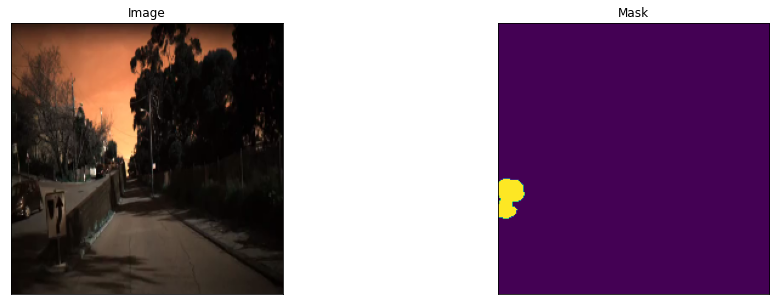

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# check what we have
pr_mask = np.load(os.path.join(par.mask_dir, '000', '0000000000.npy'))
print(pr_mask.shape)

visualize(image=image_v, mask=pr_mask)